<a href="https://colab.research.google.com/github/ImmatureBug/Diabetes-Prediction-Using-Traditional-Machine-Learning/blob/main/Diabetes_Prediction_Using_Traditional_Machine_Learning_Techniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

installation of package

In [1]:
!pip install shap dalex -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 15.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


import of what will be needed

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score,
                            classification_report, confusion_matrix, ConfusionMatrixDisplay)
import shap
import joblib

Load dataset

In [3]:
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
columns = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness",
           "Insulin", "BMI", "DiabetesPedigree", "Age", "Outcome"]
df = pd.read_csv(url, names=columns)

Handle missing values (0 → NaN → median)

In [5]:
medical_cols = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
df[medical_cols] = df[medical_cols].replace(0, np.nan)
df = df.fillna(df.median())

Feature engineering

In [4]:
df["Glucose_BMI"] = df["Glucose"] * df["BMI"]
df["Metabolic_Age"] = df["BMI"] * df["Age"]

Split data

In [6]:
X = df.drop("Outcome", axis=1)
y = df["Outcome"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    stratify=y, random_state=42)

Feature scaling

In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


 Initialize models

In [9]:
models = {
    "Decision Tree": DecisionTreeClassifier(max_depth=5, random_state=42),
    "Naive Bayes": GaussianNB(),
    "kNN": KNeighborsClassifier(n_neighbors=11),
    "Logistic Regression": LogisticRegression(max_iter=1000)  # Baseline
}

Train/evaluate all models

In [10]:
results = {}
for name, model in models.items():
    # Cross-validation
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='roc_auc')
    print(f"{name} CV ROC AUC: {np.mean(cv_scores):.3f} ± {np.std(cv_scores):.3f}")

Decision Tree CV ROC AUC: 0.769 ± 0.062
Naive Bayes CV ROC AUC: 0.834 ± 0.020
kNN CV ROC AUC: 0.824 ± 0.037
Logistic Regression CV ROC AUC: 0.839 ± 0.029


Final training


--- Decision Tree Evaluation ---
Accuracy: 0.708
F1 Score: 0.526
ROC AUC: 0.764

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.84      0.79       100
           1       0.61      0.46      0.53        54

    accuracy                           0.71       154
   macro avg       0.68      0.65      0.66       154
weighted avg       0.70      0.71      0.70       154


Confusion Matrix:
[[84 16]
 [29 25]]


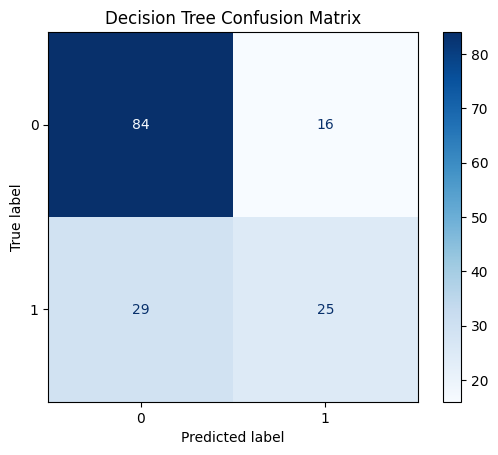


--- Naive Bayes Evaluation ---
Accuracy: 0.721
F1 Score: 0.619
ROC AUC: 0.774

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.76      0.78       100
           1       0.59      0.65      0.62        54

    accuracy                           0.72       154
   macro avg       0.70      0.70      0.70       154
weighted avg       0.73      0.72      0.72       154


Confusion Matrix:
[[76 24]
 [19 35]]


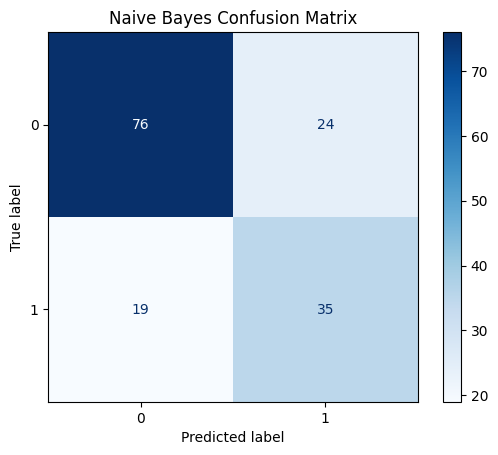


--- kNN Evaluation ---
Accuracy: 0.708
F1 Score: 0.545
ROC AUC: 0.797

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.82      0.78       100
           1       0.60      0.50      0.55        54

    accuracy                           0.71       154
   macro avg       0.68      0.66      0.67       154
weighted avg       0.70      0.71      0.70       154


Confusion Matrix:
[[82 18]
 [27 27]]


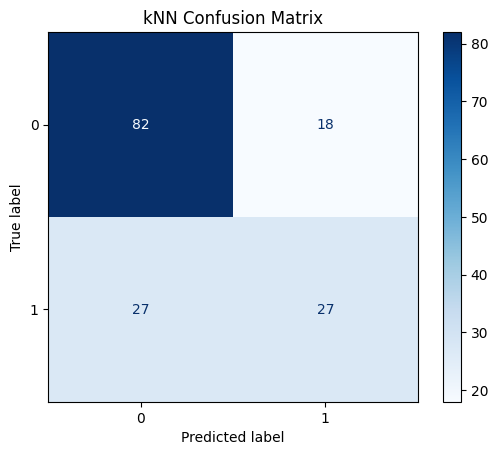


--- Logistic Regression Evaluation ---
Accuracy: 0.708
F1 Score: 0.554
ROC AUC: 0.812

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.81      0.78       100
           1       0.60      0.52      0.55        54

    accuracy                           0.71       154
   macro avg       0.68      0.66      0.67       154
weighted avg       0.70      0.71      0.70       154


Confusion Matrix:
[[81 19]
 [26 28]]


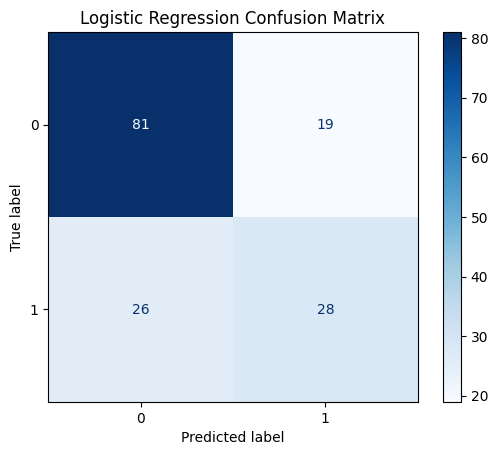

In [15]:
results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, "predict_proba") else None

    # Evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None
    report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    results[name] = {
        "Accuracy": accuracy,
        "F1 Score": f1,
        "ROC AUC": roc_auc,
        "Classification Report": report,
        "Confusion Matrix": cm
    }

    print(f"\n--- {name} Evaluation ---")
    print(f"Accuracy: {accuracy:.3f}")
    print(f"F1 Score: {f1:.3f}")
    if roc_auc is not None:
        print(f"ROC AUC: {roc_auc:.3f}")
    print("\nClassification Report:")
    print(report)
    print("\nConfusion Matrix:")
    print(cm)

    # Confusion matrix plot
    ConfusionMatrixDisplay.from_estimator(model, X_test_scaled, y_test, cmap='Blues')
    plt.title(f"{name} Confusion Matrix")
    plt.show()

Model comparison

In [20]:
results_df = pd.DataFrame(results).T
print("\nModel Comparison:")
print(results_df.sort_values("ROC AUC", ascending=False))


Model Comparison:
                     Accuracy  F1 Score   ROC AUC  \
Logistic Regression  0.707792  0.554455  0.812222   
kNN                  0.707792  0.545455  0.796574   
Naive Bayes          0.720779  0.619469  0.774074   
Decision Tree        0.707792  0.526316  0.763889   

                                                 Classification Report  \
Logistic Regression                precision    recall  f1-score   ...   
kNN                                precision    recall  f1-score   ...   
Naive Bayes                        precision    recall  f1-score   ...   
Decision Tree                      precision    recall  f1-score   ...   

                         Confusion Matrix  
Logistic Regression  [[81, 19], [26, 28]]  
kNN                  [[82, 18], [27, 27]]  
Naive Bayes          [[76, 24], [19, 35]]  
Decision Tree        [[84, 16], [29, 25]]  


HAP analysis for Decision Tree (best interpretability)

In [18]:
best_model = models["Decision Tree"]
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

Visualize feature importance

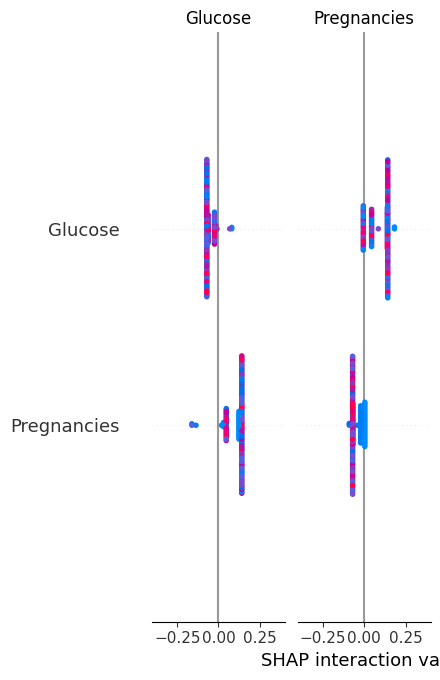

In [22]:
shap.summary_plot(shap_values, X_test, feature_names=X.columns, plot_type="bar")

Risk explanation function

In [36]:
def generate_risk_report(patient_data, model, scaler, feature_names):
    scaled_data = scaler.transform([patient_data])
    proba = model.predict_proba(scaled_data)[0][1]

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(scaled_data)

    report = f"Diabetes Risk Probability: {proba*100:.1f}%\n\nTop Risk Factors:\n"
    # Correct indexing for a single sample and positive class
    for i in np.argsort(-np.abs(shap_values[0][1]))[:3]:  # Top 3 features
        effect = shap_values[0][1][i]
        direction = "increases" if effect > 0 else "decreases"
        report += f"- {feature_names[i]} ({direction} risk)\n"

    report += "\n*Aligns with SDG 3: Early detection supports better health outcomes*"
    return report

Example prediction

In [37]:
sample_patient = X_test.iloc[0]
print(generate_risk_report(sample_patient, best_model, scaler, X.columns))

Diabetes Risk Probability: 100.0%

Top Risk Factors:
- Glucose (increases risk)
- Pregnancies (decreases risk)

*Aligns with SDG 3: Early detection supports better health outcomes*


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Save best model

In [33]:
joblib.dump(best_model, 'diabetes_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']